# CMIP6 Regrid Data

**Following steps are included in this script:**

1. Load netCDF files
2. Regrid data to 1x1° format

Save and replace netcdf files

In [50]:
# ========== Packages ==========
import sys
import os
import xesmf as xe
import xarray as xr
import pandas as pd
import numpy as np
import dask
import math
from dask.diagnostics import ProgressBar
import importlib

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

In [51]:
import importlib

# Reload the module to ensure the latest changes are reflected
importlib.reload(sd)

<module 'save_data_as_nc' from '/work/ch0636/g300115/phd_project/common/src/data_handling/save_data_as_nc.py'>

### Functions

In [22]:
def regrid(ds_dict, method='conservative'):
    """
    Combines different grid labels via interpolation with xesmf

    Args:
        ds_dict (dict): A dictionary of xarray datasets, where each key is the name of the dataset 
                        and each value is the dataset itself.
        method (str): Interpolation method for xesmf, by default 'conservative'. Other options are "nearest_s2d", 
                        "patch", "bilinear" or "conservative_normed".

    Returns:
        dict: A dictionary of combined datasets (usually will combine across different variable ids).
    """
    
    lon_degree = 1
    lat_degree = 1
    
    # Define your output grid (with cell boundaries)
    out_lon = np.arange(-180, 180, lon_degree) 
    out_lat = np.arange(-90, 90, lat_degree)
    
    

    # Calculate boundaries as midpoints between centers
    out_lon_b = (out_lon[:-1] + out_lon[1:]) / 2  # longitude boundaries
    out_lat_b = (out_lat[:-1] + out_lat[1:]) / 2  # latitude boundaries

    # Add boundary points at the start and end of the grid
    out_lon_b = np.concatenate([out_lon[0:1] - (out_lon[1]-out_lon[0])/2, out_lon_b, out_lon[-1:] + (out_lon[-1]-out_lon[-2])/2])
    out_lat_b = np.concatenate([out_lat[0:1] - (out_lat[1]-out_lat[0])/2, out_lat_b, out_lat[-1:] + (out_lat[-1]-out_lat[-2])/2])

    # Create a grid Dataset
    ds_out = xr.Dataset(
        {
            'lat': (['lat'], out_lat),
            'lon': (['lon'], out_lon),
            'lat_b': (['lat_b'], out_lat_b),
            'lon_b': (['lon_b'], out_lon_b),
        }
    )

    for i, (name, ds) in enumerate(ds_dict.items()):
        # Check if lat/lon in dataset
        if ('lat' in ds.coords) and ('lon' in ds.coords):

            # Check if regridding is necessary
            if ds['lat'].equals(ds_out['lat']) and ds['lon'].equals(ds_out['lon']): # regridding not necessary
                    ds_dict[name] = ds 
                    print(f"Grid of {name} already requested format")
            else:
                # Initialize regridder
                regridder = xe.Regridder(ds, ds_out, method, ignore_degenerate=True, periodic=True)

                # Regrid data
                reg_ds = regridder(ds, keep_attrs=True)

                # Assign attributes
                reg_ds.attrs.update(ds.attrs)
                
                 # Add comment about changes to data
                if 'log' in reg_ds.attrs:
                    log_old = reg_ds.attrs['log']
                    reg_ds.attrs['log'] = f'Regridded to {lon_degree}x{lat_degree}° lonxlat grid using {method} interpolation. // {log_old}'
                else:
                    reg_ds.attrs['log'] = 'Regridded to {lon_degree}x{lat_degree}° lonxlat grid using {method} interpolation.'

                # Update the ds_dict with the regridded dataset
                ds_dict[name] = reg_ds
        else:
            raise ValueError(f"No lat and lon in dataset '{name}'.")

    
    return ds_dict

### 1. Load netCDF files

In [103]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['ssp370']
temp_res = 'month'
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']
variables=['ps', 'huss', 'evspsbl', 'tran', 'gpp', 'tas', 'pr', 'lai', 'mrso', 'mrro'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

No file found for variable 'huss' in model 'CAMS-CSM1-0'.
No file found for variable 'gpp' in model 'CAMS-CSM1-0'.
Model 'CAMS-CSM1-0' is missing variables: huss, gpp
No file found for variable 'gpp' in model 'GFDL-ESM4'.
Model 'GFDL-ESM4' is missing variables: gpp
[########################################] | 100% Completed | 105.86 s


['ssp370']


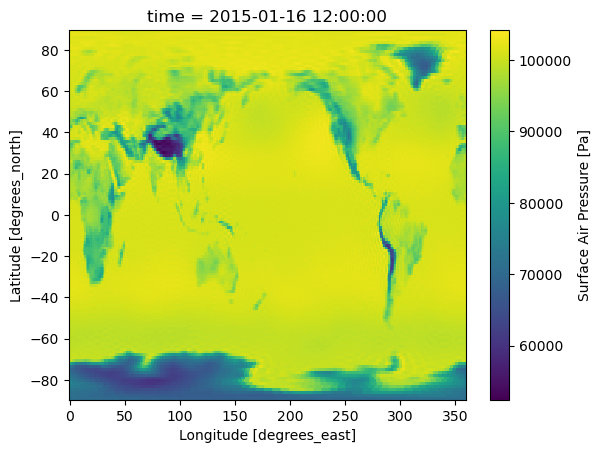

In [108]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[3]][variables[0]].isel(time=0).plot()

### Regrid data

In [109]:
ds_dict = regrid(ds_dict[experiments[0]], method='conservative')

/work/ch0636/g300115/.conda/envs/mypy3/lib/python3.10/site-packages/cf_xarray/accessor.py:1772: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/work/ch0636/g300115/.conda/envs/mypy3/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/work/ch0636/g300115/.conda/envs/mypy3/lib/python3.10/site-packages/cf_xarray/accessor.py:1772: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/work/ch0636/g300115/.conda/envs/mypy3/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/work/ch0636/g300115/.conda/envs/mypy3/lib/python3.10/site-packages/cf_xarray/accessor.py:1772: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings

In [75]:
# Regrid landmask
#ds_dict[list(ds_dict.keys())[0]]['landseamask'].to_netcdf('../../data/landmask/land_sea_mask_1x1_grid.nc')

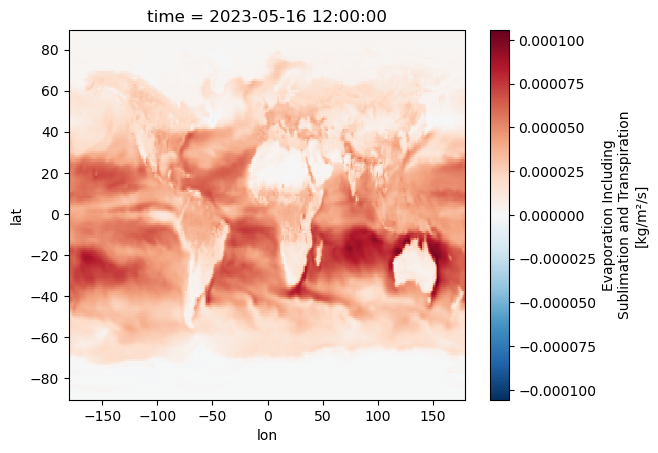

In [117]:
# ========= Have a look into the dictionary =======
ds_dict[models[6]][variables[2]].isel(time=100).plot()

### Save data

In [118]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/


In [119]:
sd.save_files(ds_dict, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/ps/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/ps/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/huss/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/huss/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/gpp/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/